# Tutorial 4 (24th, March)

what's covered:
1. DFT & DCT
2. Quantization

* Some parts might overlap with ELEC5304, and credits go to Senhui Guo.

---

## 1. DFT & DCT

Recall last time we do JPEG, an image compression technique, in one line of code, to compress the squitward image of different compression ratio. This time we will do some basic compression tricks with what you just learned from the lectures.

Let's first save and load the image.

In [4]:
!curl https://paisano-online.com/wp-content/uploads/2020/02/File_001.jpg > squit.jpg

  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100  103k  100  103k    0     0   736k      0 --:--:-- --:--:-- --:--:--  736k


(-0.5, 943.5, 768.5, -0.5)

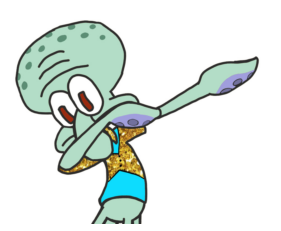

In [43]:
import matplotlib.pyplot as plt

original_img = plt.imread('squit.jpg')
plt.imshow(original_img, interpolation='bilinear')
plt.axis('off')

### 1.1 Discrete Fourier Transform (DFT)

Fourier transformation works on scalar values. For simplicity, we use gray scale image for demonstration. For RGB images, a naive way is to simply do the same thing for each channel.

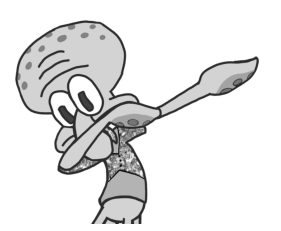

In [44]:
from skimage import color

grayscale_img = color.rgb2gray(original_img)
plt.imshow(grayscale_img, cmap='gray')
plt.axis('off')
plt.show()

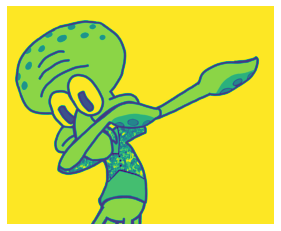

In [45]:
# why set ```cmap='gray'```
# by default it will intepret the image as a color one of three channels.
plt.imshow(grayscale_img)
plt.axis('off')
plt.show()

Now let's do Fourier transformation. There's several popular packages that can do this, e.g. scipy and OpenCV. It's just one line of code to call a function, and of course you can use your favorite one. For now let's take scipy for this example. We will pickup OpenCV for a later example.

The output of the Fourier transformation contains the complex part, which
the drawing library is not designed to handle, we need to get rid of the complex part first. To
maintain the intensity, we can’t just keep the real part only, we need to calculate the norm of the
complex number, we can simply use the np.abs function to calculate the absolute values.

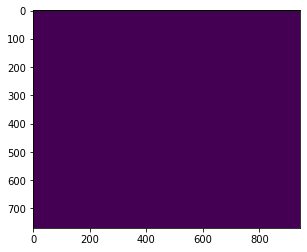

In [46]:
from scipy import fftpack
import numpy as np

img = grayscale_img
img_fft = fftpack.fft2(img)

plt.imshow(np.abs(img_fft))
plt.show()

Something else went wrong, the map looks trivial, we can’t see any meaningful information, the
reason is that the values in the matrix are not at the same level, so only a tiny proportion of the
pixels got lighten up, which we can’t even see. Hence we need to rescale the image with np.log() function.

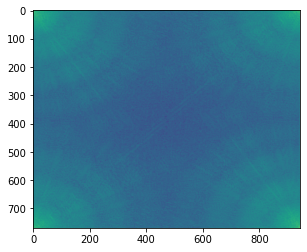

In [47]:
# we use np.abs to get the absolute value of the result of the Fourier Transform,
# as the visualization api , matplotlib in this case, cannot work with complex value.

# we use np.log to rescale the value range, as there can be extremely large numbers 
# in the result of the Fourier Transform. Of course there's other ways of doing this,
# but log is perhaps one of the most simple way.

plt.imshow(np.log(np.abs(img_fft)))
plt.show()

(-0.5, 943.5, 768.5, -0.5)

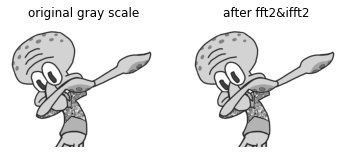

In [48]:
# Let's try to transform the image in frequency domain back to spatial domain.

restored_img = fftpack.ifft2(img_fft).real

fig, axes = plt.subplots(1,2)
axes[0].imshow(grayscale_img, cmap='gray')
axes[0].set_title('original gray scale')
axes[0].axis('off')
axes[1].imshow(restored_img, cmap='gray')
axes[1].set_title('after fft2&ifft2')
axes[1].axis('off')

# The differences are barely noticable.

Now we can see the frequency information from the Fourier transformation, the corner part is the
low frequency information, and the center piece is the high frequency information, now let’s see
what visual information do they store exactly.

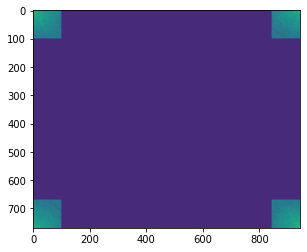

In [50]:
# Let's play around with the image in frequency domain.
# First try to remove high-frequency information.

def keep_corner(img_fft, width, v_pad=0):
  # the padding value is supposed to be zero, but set to 1 when use log as normalization.
    compressed_img_fft = img_fft.copy()
    # because the operation we do will directly alter the
    # data section, so we need to make a copy to isolate
    # the original data from our operations
    compressed_img_fft[width:-width,:] = v_pad
    compressed_img_fft[:,width:-width] = v_pad
    return compressed_img_fft

plt.imshow(np.log(np.abs(keep_corner(img_fft, 100, v_pad=1))))

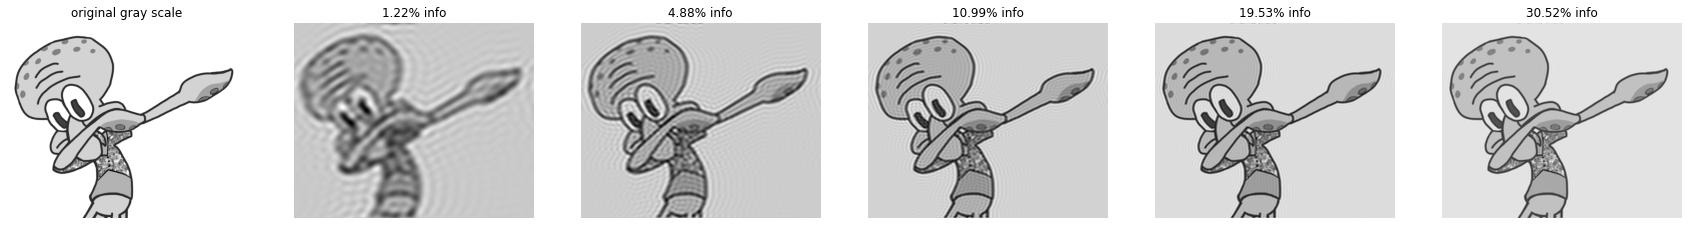

In [30]:
# Test with different loss ratio of high-frequency info in frequency domain

fig, axes = plt.subplots(1,6)
fig.set_figheight(5)
fig.set_figwidth(30)
axes[0].imshow(grayscale_img, cmap='gray')
axes[0].set_title('original gray scale')
axes[0].axis('off')

for idx in range(1,6):
    width = 20*idx
    axes[idx].imshow(fftpack.ifft2(keep_corner(img_fft, width)).real, cmap='gray')
    axes[idx].set_title(f'{2*4*(width**2)/(512*512):.2%} info')
    axes[idx].axis('off')

We can see that even we only kept 30% of the original information, the visual loss is almost undetectable. 

Now let's do the same thing with low frequency information

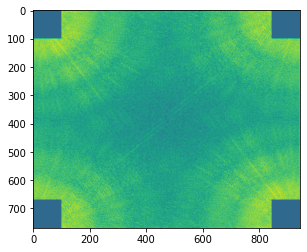

In [49]:
# Then we try to remove low-frequency information.

def keep_center(img_fft, width, v_pad=0):
    compressed_img_fft = img_fft.copy()
    compressed_img_fft[:width,:width] = v_pad
    compressed_img_fft[:width,-width:] = v_pad
    compressed_img_fft[-width:,:width] = v_pad
    compressed_img_fft[-width:,-width:] = v_pad
    return compressed_img_fft

plt.imshow(np.log(np.abs(keep_center(img_fft, 100, 1))))

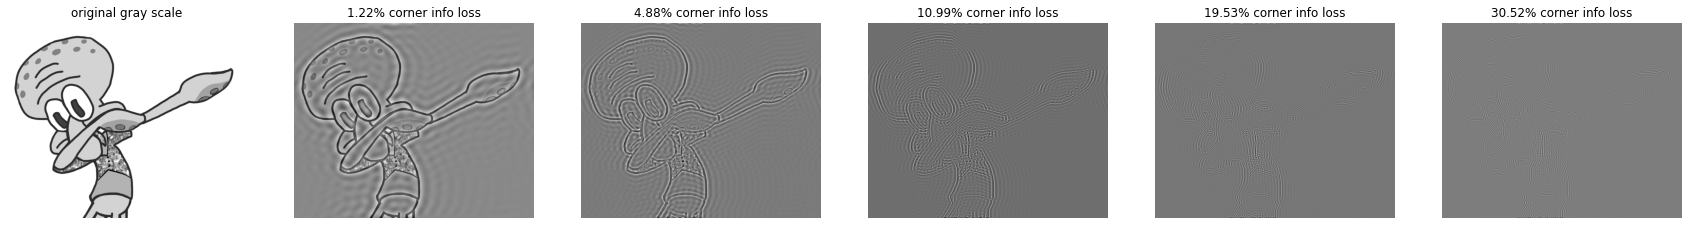

In [50]:
# Test with different loss ratio of high-frequency info in frequency domain

fig, axes = plt.subplots(1,6)
fig.set_figheight(5)
fig.set_figwidth(30)
axes[0].imshow(grayscale_img, cmap='gray')
axes[0].set_title('original gray scale')
axes[0].axis('off')

for idx in range(1,6):
    width = 20*idx
    axes[idx].imshow(fftpack.ifft2(keep_center(img_fft, width)).real, cmap='gray')
    axes[idx].set_title(f'{2*4*(width**2)/(512*512):.2%} corner info loss')
    axes[idx].axis('off')

From images above, we could observe that low-frequency components store the general structure and smooth features of the image, while high-frequency components store the sharp edges and fine details.

### 2.2 Discrete Cosine Transform (DCT)

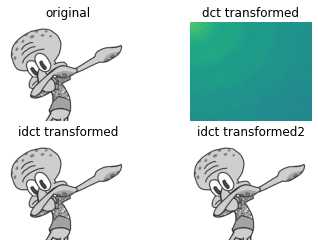

In [52]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
 
img = cv2.imread('squit.jpg', 0) #Read the picture,

img1 = img.astype('float')[:-1] #Convert uint8 to float type

img_dct = cv2.dct(img1) #Perform discrete cosine transform
 
img_dct_log = np.log(np.abs(img_dct)) #do log processing
 
img_recor = cv2.idct(img_dct) #Perform inverse discrete cosine transform
 
# Picture compression, only keep 100*100 data
recor_temp = img_dct[0:100,0:100]
recor_temp2 = np.zeros(img1.shape)
recor_temp2[0:100,0:100] = recor_temp
recor_temp2 = img_dct[:, :]
 #Compressed picture recovery
img_recor1 = cv2.idct(recor_temp2)
 
 #display
plt.subplot(221)
plt.imshow(img, cmap='gray')
plt.title('original')
plt.axis('off')
 
plt.subplot(222)
plt.imshow(img_dct_log)
plt.title('dct transformed')
plt.axis('off')
 
plt.subplot(223)
plt.imshow(img_recor, cmap='gray')
plt.title('idct transformed')
plt.axis('off')
 
plt.subplot(224)
plt.imshow(img_recor1, cmap='gray')
plt.title('idct transformed2')
plt.axis('off')

plt.show()


## 2. Quantization


Quantization is a much more straightforward compression method called quantization. It’s a
method very easy to implement using some simple operations.

The pixel values in an image is on a continuous interval from 0 to 256, however the distribution or
density of those values is not equal, for a specific image, some interval of color may appear more
often compared to some other intervals.

Let’s say we have a 10x10 image with integers from 0 to 255, we need 100 * 8 = 800 bits to store
all of the information. Now if the pixels in the image have only 8 possible values, e.g. 0, 31, 63,
95, 127, 159, 191, 255, now each pixel only need a 3-bit number to record it’s information, all it
needs to do is to identify which number within the 8 possibilities, and we need additional 8 8-bit
numbers to store the specific possible values, overall, we need 100*3 + 8*8 = 364 bits to store all
of the information, which is a huge reduction compared to the original 800 bits.

Now in a real world situation, the numbers are going to be distributed all over the interval, however
some numbers will have more appearances compared to others, and these numbers are more
representing. What we need to do is to find such 8 most representing numbers using clustering
and then reassign the value of all pixels to the closest representing number in this small set of 8
representing numbers, to lower the graniness of the image.

Automatically created module for IPython interactive environment


<ipython-input-76-194b1f367969>:17: DeprecationWarning: scipy.misc.face has been deprecated in SciPy v1.10.0; and will be completely removed in SciPy v1.12.0. Dataset methods have moved into the scipy.datasets module. Use scipy.datasets.face instead.
  face = face(gray=True)


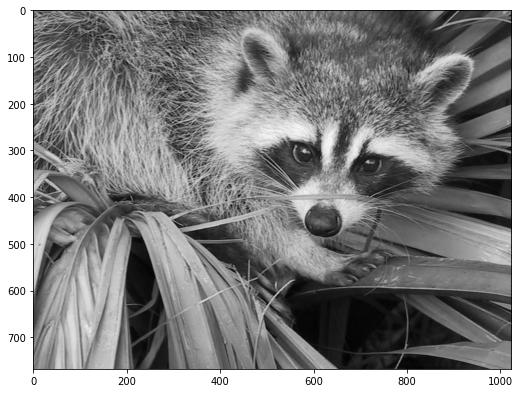

In [76]:
print(__doc__)


# Code source: Gaël Varoquaux
# Modified for documentation by Jaques Grobler
# License: BSD 3 clause

import numpy as np
import scipy as sp
import matplotlib.pyplot as plt

from sklearn import cluster


try:  # SciPy >= 0.16 have face in misc
    from scipy.misc import face
    face = face(gray=True)
except ImportError:
    face = sp.face(gray=True)

n_clusters = 8
np.random.seed(0)

X = face.reshape((-1, 1))  # We need an (n_sample, n_feature) array
# n_feature means pixel value here.
k_means = cluster.KMeans(n_clusters=n_clusters, n_init=4)
k_means.fit(X)
values = k_means.cluster_centers_.squeeze()
labels = k_means.labels_

# create an array from labels and values
face_compressed = np.choose(labels, values)
face_compressed.shape = face.shape

vmin = face.min()
vmax = face.max()

# original face
plt.figure(1, figsize=(9, 6.6))
plt.imshow(face, cmap=plt.cm.gray, vmin=vmin, vmax=256)

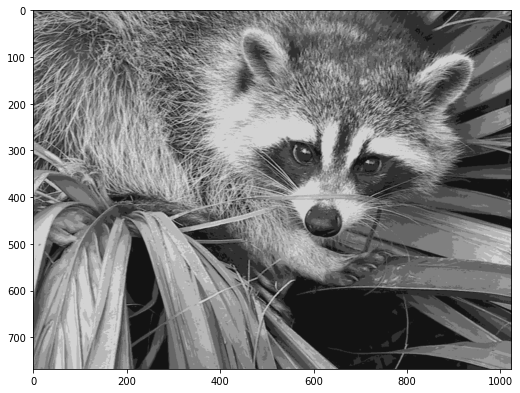

In [77]:
# compressed face
plt.figure(2, figsize=(9, 6.6))
plt.imshow(face_compressed, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)

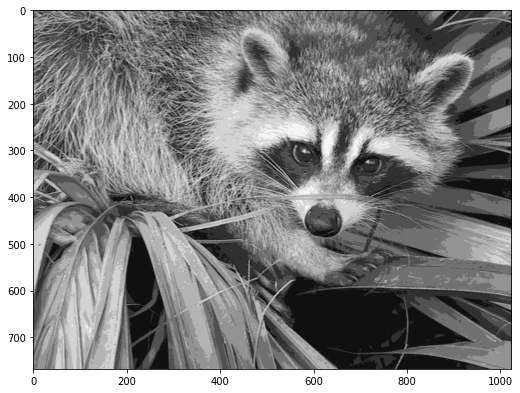

In [78]:
# equal bins face, or uniform quantization
regular_values = np.linspace(0, 256, n_clusters + 1)
regular_labels = np.searchsorted(regular_values, face) - 1
regular_values = .5 * (regular_values[1:] + regular_values[:-1])  # mean
regular_face = np.choose(regular_labels.ravel(), regular_values, mode="clip")
regular_face.shape = face.shape
plt.figure(3, figsize=(9, 6.6))
plt.imshow(regular_face, cmap=plt.cm.gray, vmin=vmin, vmax=vmax)

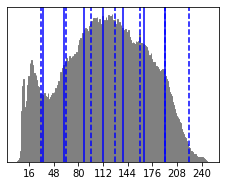

[  0   1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17
  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35
  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53
  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71
  72  73  74  75  76  77  78  79  80  81  82  83  84  85  86  87  88  89
  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107
 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125
 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143
 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158 159 160 161
 162 163 164 165 166 167 168 169 170 171 172 173 174 175 176 177 178 179
 180 181 182 183 184 185 186 187 188 189 190 191 192 193 194 195 196 197
 198 199 200 201 202 203 204 205 206 207 208 209 210 211 212 213 214 215
 216 217 218 219 220 221 222 223 224 225 226 227 228 229 230 231 232 233
 234 235 236 237 238 239 240 241 242 243 244 245 24

In [41]:
# histogram
plt.figure(4, figsize=(3, 2.2))
plt.clf()
plt.axes([.01, .01, .98, .98])
plt.hist(X, bins=256, color='.5', edgecolor='.5')
plt.yticks(())
plt.xticks(regular_values)
values = np.sort(values)
for center_1, center_2 in zip(values[:-1], values[1:]):
    plt.axvline(.5 * (center_1 + center_2), color='b')

for center_1, center_2 in zip(regular_values[:-1], regular_values[1:]):
    plt.axvline(.5 * (center_1 + center_2), color='b', linestyle='--')

plt.show()

print(np.unique(face))
print(np.unique(face_compressed))
print(np.unique(regular_face))

In [12]:
from skimage.metrics import structural_similarity as ssim

print(ssim(face, face_compressed, data_range=face_compressed.max()-face_compressed.min()))
print(ssim(face, regular_face, data_range=regular_face.max()-regular_face.min()))

0.8392193957749253
0.8269249507549602


## 4. QUIZ
Use the example in Section 3.
Quantization. Perform a quantization with k-means for color image.